# ML-Project


>Kimia Fakheri -Sara Rezanejad



#Simulation Question 1:

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def load_and_preprocess_data(batch_size=64):
    # CIFAR-10 normalization parameters
    normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                     std=[0.2023, 0.1994, 0.2010])

    # Define transformations including normalization
    transform = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])

    # Load CIFAR-10 dataset
    train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
    test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

    # Create data loaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)

    return train_loader, test_loader

train_loader, test_loader = load_and_preprocess_data()

100%|██████████| 170498071/170498071 [00:10<00:00, 15809508.03it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import copy
def create_model(device=device):
# Load the pre-trained model
    model = torchvision.models.resnet18(pretrained=True)
# Add more layers to the model
    model.fc = nn.Sequential(
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 10)  # CIFAR10 has 10 classes
    )
    return model.to(device)

model = create_model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, epochs, shardNum, device=device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.train()
    model.to(device)

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the appropriate device
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        print(f"Shard [{shardNum}], Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    return model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, Subset

def sisa_training(train_data, shards, slices, epochs_per_slice, device=device):
    shard_size = len(train_data) // shards
    models = []

    for s in range(shards):
        shard_data = Subset(train_data, range(s * shard_size, (s + 1) * shard_size))
        shard_loader = DataLoader(shard_data, batch_size=64, shuffle=True, pin_memory=True, num_workers=2)

        slice_size = shard_size // slices
        slice_models = []

        for r in range(slices):
            slice_data = Subset(shard_data, range(0, (r + 1) * slice_size))
            slice_loader = DataLoader(slice_data, batch_size=64, shuffle=True, pin_memory=True, num_workers=2)
            if r == 0:
                model = create_model(device=device)
                model = train_model(model, slice_loader, epochs_per_slice, s, device)
            else:
                model = train_model(model, slice_loader, epochs_per_slice, s, device)

            slice_models.append(model)

        models.append(slice_models)

    return models

#Simulation Question 2 , 3:

In [ ]:
import torch
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
import numpy as np

def evaluate_models(models_list, test_loader, device):
    all_labels = []
    all_probs = []
    all_preds = []

    # Set all models to evaluation mode
    for models in models_list:
        models[-1].eval()

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Collect predictions and probabilities from all models
            model_probs = []
            for models in models_list:
                model = models[-1]
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1)
                model_probs.append(probs.cpu().numpy())

            # Average probabilities
            avg_probs = np.mean(np.array(model_probs), axis=0)
            majority_vote_preds = np.argmax(avg_probs, axis=1)

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(avg_probs)
            all_preds.extend(majority_vote_preds)

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')

    # Compute AUROC for multi-class
    try:
        auroc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
    except ValueError:
        auroc = None  # Handle case where roc_auc_score cannot be computed

    return accuracy, f1, recall, precision, auroc

In [ ]:
# Unlearn
import random
from collections import defaultdict
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn import linear_model, model_selection
num = 50000
N = 50000
random_numbers = [random.randint(0, num) for _ in range(500)]
random_numbers.sort()

remaining_indices = list(set(range(N)) - set(random_numbers))

trainset = train_loader.dataset

subset1 = Subset(trainset, random_numbers)
subset2 = Subset(trainset, remaining_indices)

# Create data loaders
forgetloader = DataLoader(subset1, batch_size=64, shuffle=True)
retainloader = DataLoader(subset2, batch_size=64, shuffle=True)

def sisa_unlearning(M_ks, random_numbers, shards, slices, epochs_per_slice, train_data, device, num=60000):
    intervals = [(i*num/shards+j*num/shards/slices, i*num/shards+(j+1)*num/shards/slices) for i in range(shards) for j in range(slices)]
    sli = {i*num/shards+j*num/shards/slices: (i, j) for i in range(shards) for j in range(slices)}

    unlearn_indices = random_numbers.copy()
    numbers_in_intervals = []
    unlearn_slices = []

    for lower_bound, upper_bound in intervals:
        number_in_interval = next((num for num in random_numbers if lower_bound <= num <= upper_bound), None)
        if number_in_interval is not None:
            numbers_in_intervals.append(number_in_interval)
            random_numbers.remove(number_in_interval)
            if sli[lower_bound][0] not in [slcs[0] for slcs in unlearn_slices]:
                unlearn_slices.append(sli[lower_bound])

    to_delete = defaultdict(list)
    for i in unlearn_indices:
        to_delete[i // (num // shards)].append(i % (num // shards))

    train_data_shards = [Subset(train_data, range(i * (num // shards), (i + 1) * (num // shards))) for i in range(shards)]

    for shrd, slc in unlearn_slices:
        j = slc
        if j == 0:
            model = create_model(device=device)
        else:
            model = M_ks[shrd][j-1]

        while j != slices:
            ts = Subset(train_data_shards[shrd], range((j + 1) * len(train_data) // shards // slices))
            data = torch.stack([item[0] for item in ts]).to(device)
            indices_to_remove = [i for i in to_delete[shrd] if i < (j + 1) * len(train_data) // shards // slices]
            mask = torch.ones(len(data), dtype=bool)
            mask[indices_to_remove] = False
            filtered_data = data[mask]
            targets = torch.tensor([item[1] for item in ts]).to(device)
            filtered_targets = targets[mask]

            filtered_dataset = TensorDataset(filtered_data, filtered_targets)
            trainloader = DataLoader(filtered_dataset, batch_size=128, shuffle=True)

            model = train_model(model, trainloader, epochs=epochs_per_slice, shardNum=shrd, device=device)

            M_ks[shrd][j] = model
            j += 1

    return M_ks

def compute_losses(models, dataloader, shards, slices, device):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        logits = 0
        for i in range(shards):
            model = models[i][slices - 1]
            model = model.to(device)
            outputs = model(inputs)
            logits += outputs.data / shards
        losses = criterion(logits, targets).cpu().numpy()  # Ensure the losses are moved to CPU before converting to numpy
        all_losses.extend(losses)

    return np.array(all_losses)

def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack."""

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

def consolidated_function(models, loader1, loader2, shards, slices, device, n_splits=10, random_state=0, num_data=500):
    """Combines the process of computing losses, balancing loaders, and performing MIA."""

    # Compute losses
    loader1_losses = compute_losses(models, loader1, shards, slices, device)
    loader2_losses = compute_losses(models, loader2, shards, slices, device)

    np.random.shuffle(loader1_losses)
    loader1_losses = loader1_losses[:num_data]
    np.random.shuffle(loader2_losses)
    loader2_losses = loader2_losses[:num_data]

    # Prepare samples and labels for MIA
    samples_mia = np.concatenate((loader2_losses, loader1_losses)).reshape((-1, 1))
    labels_mia = [0] * len(loader2_losses) + [1] * len(loader1_losses)

    # Perform MIA
    mia_scores = simple_mia(samples_mia, labels_mia, n_splits=n_splits, random_state=random_state)

    return mia_scores

# Learn S=5, R=5:

In [ ]:
epochs_per_slice = 3  # Number of epochs for each slice
shards = 5
slices = 5
trained_models = sisa_training(train_loader.dataset, shards, slices, epochs_per_slice, device)
f1, accuracy, precision, recall, auroc = evaluate_models(trained_models, test_loader, device)
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUROC: {auroc}")
# Simulation Question 3:
print(f"MIA Cross-Validation Score for retainset, and test set for trained(not unlearned model): {np.mean(consolidated_function(trained_models, retainloader, test_loader, shards, slices, device))}")
print(f"MIA Cross-Validation Score for forgetset, and test set for trained(not unlearned model): {np.mean(consolidated_function(trained_models, forgetloader, test_loader, shards, slices, device))}")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 71.8MB/s]


Shard [0], Epoch [1/3], Loss: 1.8900, Accuracy: 31.85%
Shard [0], Epoch [2/3], Loss: 1.2762, Accuracy: 57.00%
Shard [0], Epoch [3/3], Loss: 1.0835, Accuracy: 64.75%
Shard [0], Epoch [1/3], Loss: 1.2470, Accuracy: 61.23%
Shard [0], Epoch [2/3], Loss: 0.9222, Accuracy: 71.38%
Shard [0], Epoch [3/3], Loss: 0.7706, Accuracy: 76.83%
Shard [0], Epoch [1/3], Loss: 0.9270, Accuracy: 72.55%
Shard [0], Epoch [2/3], Loss: 0.7036, Accuracy: 78.73%
Shard [0], Epoch [3/3], Loss: 0.5748, Accuracy: 83.42%
Shard [0], Epoch [1/3], Loss: 0.6952, Accuracy: 80.01%
Shard [0], Epoch [2/3], Loss: 0.5453, Accuracy: 84.28%
Shard [0], Epoch [3/3], Loss: 0.4480, Accuracy: 87.46%
Shard [0], Epoch [1/3], Loss: 0.5236, Accuracy: 85.19%
Shard [0], Epoch [2/3], Loss: 0.4012, Accuracy: 88.29%
Shard [0], Epoch [3/3], Loss: 0.3345, Accuracy: 90.57%
Shard [1], Epoch [1/3], Loss: 1.8973, Accuracy: 33.35%
Shard [1], Epoch [2/3], Loss: 1.3833, Accuracy: 51.95%
Shard [1], Epoch [3/3], Loss: 1.0792, Accuracy: 64.80%
Shard [1],

# Unlearn S=5, R=5:

In [ ]:
trained_models = sisa_unlearning(trained_models, random_numbers, shards, slices, epochs_per_slice, train_loader.dataset, device)
f1, accuracy, precision, recall, auroc = evaluate_models(trained_models, test_loader, device)
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUROC: {auroc}")
# Simulation Question 3:
print(f"MIA Cross-Validation Score for retainset, and test set for unlearned model: {np.mean(consolidated_function(trained_models, retainloader, test_loader, shards, slices, device))}")
print(f"MIA Cross-Validation Score for forgetset, and test set for unlearned model: {np.mean(consolidated_function(trained_models, forgetloader, test_loader, shards, slices, device))}")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Shard [0], Epoch [1/3], Loss: 1.9004, Accuracy: 31.78%
Shard [0], Epoch [2/3], Loss: 1.1869, Accuracy: 60.08%
Shard [0], Epoch [3/3], Loss: 0.8016, Accuracy: 74.38%
Shard [0], Epoch [1/3], Loss: 1.0132, Accuracy: 69.05%
Shard [0], Epoch [2/3], Loss: 0.6922, Accuracy: 79.22%
Shard [0], Epoch [3/3], Loss: 0.4905, Accuracy: 85.98%
Shard [0], Epoch [1/3], Loss: 0.7760, Accuracy: 77.32%
Shard [0], Epoch [2/3], Loss: 0.5087, Accuracy: 85.16%
Shard [0], Epoch [3/3], Loss: 0.3790, Accuracy: 88.96%
Shard [0], Epoch [1/3], Loss: 0.5788, Accuracy: 83.58%
Shard [0], Epoch [2/3], Loss: 0.3879, Accuracy: 89.22%
Shard [0], Epoch [3/3], Loss: 0.3186, Accuracy: 91.33%
Shard [0], Epoch [1/3], Loss: 0.4633, Accuracy: 86.89%
Shard [0], Epoch [2/3], Loss: 0.3125, Accuracy: 91.31%
Shard [0], Epoch [3/3], Loss: 0.2672, Accuracy: 92.40%
Shard [1], Epoch [1/3], Loss: 2.0144, Accuracy: 24.75%
Shard [1], Epoch [2/3], Loss: 1.2736, Accuracy: 56.96%
Shard [1], Epoch [3/3], Loss: 0.9132, Accuracy: 70.97%
Shard [1],

# Learn S=5, R=10:

In [ ]:
epochs_per_slice = 3  # Number of epochs for each slice
shards = 5
slices = 10
trained_models = sisa_training(train_loader.dataset, shards, slices, epochs_per_slice, device)
f1, accuracy, precision, recall, auroc = evaluate_models(trained_models, test_loader, device)
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUROC: {auroc}")
# Simulation Question 3:
print(f"MIA Cross-Validation Score for retainset, and test set for trained(not unlearned model): {np.mean(consolidated_function(trained_models, retainloader, test_loader, shards, slices, device))}")
print(f"MIA Cross-Validation Score for forgetset, and test set for trained(not unlearned model): {np.mean(consolidated_function(trained_models, forgetloader, test_loader, shards, slices, device))}")

# Unlearn S=5, R=10:

In [ ]:
trained_models = sisa_unlearning(trained_models, random_numbers, shards, slices, epochs_per_slice, train_loader.dataset, device)
f1, accuracy, precision, recall, auroc = evaluate_models(trained_models, test_loader, device)
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUROC: {auroc}")
# Simulation Question 3:
print(f"MIA Cross-Validation Score for retainset, and test set for unlearned model: {np.mean(consolidated_function(trained_models, retainloader, test_loader, shards, slices, device))}")
print(f"MIA Cross-Validation Score for forgetset, and test set for unlearned model: {np.mean(consolidated_function(trained_models, forgetloader, test_loader, shards, slices, device))}")

# Learn S=5, R=20:

In [ ]:
epochs_per_slice = 3  # Number of epochs for each slice
shards = 5
slices = 20
trained_models = sisa_training(train_loader.dataset, shards, slices, epochs_per_slice, device)
f1, accuracy, precision, recall, auroc = evaluate_models(trained_models, test_loader, device)
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUROC: {auroc}")
# Simulation Question 3:
print(f"MIA Cross-Validation Score for retainset, and test set for trained(not unlearned model): {np.mean(consolidated_function(trained_models, retainloader, test_loader, shards, slices, device))}")
print(f"MIA Cross-Validation Score for forgetset, and test set for trained(not unlearned model): {np.mean(consolidated_function(trained_models, forgetloader, test_loader, shards, slices, device))}")

# Unlearn S=5, R=20:

In [ ]:
trained_models = sisa_unlearning(trained_models, random_numbers, shards, slices, epochs_per_slice, train_loader.dataset, device)
f1, accuracy, precision, recall, auroc = evaluate_models(trained_models, test_loader, device)
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUROC: {auroc}")
# Simulation Question 3:
print(f"MIA Cross-Validation Score for retainset, and test set for unlearned model: {np.mean(consolidated_function(trained_models, retainloader, test_loader, shards, slices, device))}")
print(f"MIA Cross-Validation Score for forgetset, and test set for unlearned model: {np.mean(consolidated_function(trained_models, forgetloader, test_loader, shards, slices, device))}")

# Learn S=10, R=5:

In [ ]:
epochs_per_slice = 3  # Number of epochs for each slice
shards = 10
slices = 5
trained_models = sisa_training(train_loader.dataset, shards, slices, epochs_per_slice, device)
f1, accuracy, precision, recall, auroc = evaluate_models(trained_models, test_loader, device)
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUROC: {auroc}")
# Simulation Question 3:
print(f"MIA Cross-Validation Score for retainset, and test set for trained(not unlearned model): {np.mean(consolidated_function(trained_models, retainloader, test_loader, shards, slices, device))}")
print(f"MIA Cross-Validation Score for forgetset, and test set for trained(not unlearned model): {np.mean(consolidated_function(trained_models, forgetloader, test_loader, shards, slices, device))}")

# Unlearn S=10, R=5:

In [ ]:
trained_models = sisa_unlearning(trained_models, random_numbers, shards, slices, epochs_per_slice, train_loader.dataset, device)
f1, accuracy, precision, recall, auroc = evaluate_models(trained_models, test_loader, device)
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUROC: {auroc}")
# Simulation Question 3:
print(f"MIA Cross-Validation Score for retainset, and test set for unlearned model: {np.mean(consolidated_function(trained_models, retainloader, test_loader, shards, slices, device))}")
print(f"MIA Cross-Validation Score for forgetset, and test set for unlearned model: {np.mean(consolidated_function(trained_models, forgetloader, test_loader, shards, slices, device))}")

# Learn S=10, R=10:

In [ ]:
epochs_per_slice = 3  # Number of epochs for each slice
shards = 10
slices = 10
trained_models = sisa_training(train_loader.dataset, shards, slices, epochs_per_slice, device)
f1, accuracy, precision, recall, auroc = evaluate_models(trained_models, test_loader, device)
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUROC: {auroc}")
# Simulation Question 3:
print(f"MIA Cross-Validation Score for retainset, and test set for trained(not unlearned model): {np.mean(consolidated_function(trained_models, retainloader, test_loader, shards, slices, device))}")
print(f"MIA Cross-Validation Score for forgetset, and test set for trained(not unlearned model): {np.mean(consolidated_function(trained_models, forgetloader, test_loader, shards, slices, device))}")

# Unlearn S=10, R=10:

In [ ]:
trained_models = sisa_unlearning(trained_models, random_numbers, shards, slices, epochs_per_slice, train_loader.dataset, device)
f1, accuracy, precision, recall, auroc = evaluate_models(trained_models, test_loader, device)
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUROC: {auroc}")
# Simulation Question 3:
print(f"MIA Cross-Validation Score for retainset, and test set for unlearned model: {np.mean(consolidated_function(trained_models, retainloader, test_loader, shards, slices, device))}")
print(f"MIA Cross-Validation Score for forgetset, and test set for unlearned model: {np.mean(consolidated_function(trained_models, forgetloader, test_loader, shards, slices, device))}")

# Learn S=10, R=20:

In [ ]:
epochs_per_slice = 3  # Number of epochs for each slice
shards = 10
slices = 20
trained_models = sisa_training(train_loader.dataset, shards, slices, epochs_per_slice, device)
f1, accuracy, precision, recall, auroc = evaluate_models(trained_models, test_loader, device)
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUROC: {auroc}")
# Simulation Question 3:
print(f"MIA Cross-Validation Score for retainset, and test set for trained(not unlearned model): {np.mean(consolidated_function(trained_models, retainloader, test_loader, shards, slices, device))}")
print(f"MIA Cross-Validation Score for forgetset, and test set for trained(not unlearned model): {np.mean(consolidated_function(trained_models, forgetloader, test_loader, shards, slices, device))}")

# Unlearn S=10, R=20:

In [ ]:
trained_models = sisa_unlearning(trained_models, random_numbers, shards, slices, epochs_per_slice, train_loader.dataset, device)
f1, accuracy, precision, recall, auroc = evaluate_models(trained_models, test_loader, device)
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUROC: {auroc}")
# Simulation Question 3:
print(f"MIA Cross-Validation Score for retainset, and test set for unlearned model: {np.mean(consolidated_function(trained_models, retainloader, test_loader, shards, slices, device))}")
print(f"MIA Cross-Validation Score for forgetset, and test set for unlearned model: {np.mean(consolidated_function(trained_models, forgetloader, test_loader, shards, slices, device))}")

# Learn S=20, R=5:

In [ ]:
epochs_per_slice = 3  # Number of epochs for each slice
shards = 20
slices = 5
trained_models = sisa_training(train_loader.dataset, shards, slices, epochs_per_slice, device)
f1, accuracy, precision, recall, auroc = evaluate_models(trained_models, test_loader, device)
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUROC: {auroc}")
# Simulation Question 3:
print(f"MIA Cross-Validation Score for retainset, and test set for trained(not unlearned model): {np.mean(consolidated_function(trained_models, retainloader, test_loader, shards, slices, device))}")
print(f"MIA Cross-Validation Score for forgetset, and test set for trained(not unlearned model): {np.mean(consolidated_function(trained_models, forgetloader, test_loader, shards, slices, device))}")

# Unlearn S=20, R=5:

In [ ]:
trained_models = sisa_unlearning(trained_models, random_numbers, shards, slices, epochs_per_slice, train_loader.dataset, device)
f1, accuracy, precision, recall, auroc = evaluate_models(trained_models, test_loader, device)
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUROC: {auroc}")
# Simulation Question 3:
print(f"MIA Cross-Validation Score for retainset, and test set for unlearned model: {np.mean(consolidated_function(trained_models, retainloader, test_loader, shards, slices, device))}")
print(f"MIA Cross-Validation Score for forgetset, and test set for unlearned model: {np.mean(consolidated_function(trained_models, forgetloader, test_loader, shards, slices, device))}")

# Learn S=20, R=10:

In [ ]:
epochs_per_slice = 3  # Number of epochs for each slice
shards = 20
slices = 10
trained_models = sisa_training(train_loader.dataset, shards, slices, epochs_per_slice, device)
f1, accuracy, precision, recall, auroc = evaluate_models(trained_models, test_loader, device)
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUROC: {auroc}")
# Simulation Question 3:
print(f"MIA Cross-Validation Score for retainset, and test set for trained(not unlearned model): {np.mean(consolidated_function(trained_models, retainloader, test_loader, shards, slices, device))}")
print(f"MIA Cross-Validation Score for forgetset, and test set for trained(not unlearned model): {np.mean(consolidated_function(trained_models, forgetloader, test_loader, shards, slices, device))}")

# Unlearn S=20, R=10:

In [ ]:
trained_models = sisa_unlearning(trained_models, random_numbers, shards, slices, epochs_per_slice, train_loader.dataset, device)
f1, accuracy, precision, recall, auroc = evaluate_models(trained_models, test_loader, device)
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUROC: {auroc}")
# Simulation Question 3:
print(f"MIA Cross-Validation Score for retainset, and test set for unlearned model: {np.mean(consolidated_function(trained_models, retainloader, test_loader, shards, slices, device))}")
print(f"MIA Cross-Validation Score for forgetset, and test set for unlearned model: {np.mean(consolidated_function(trained_models, forgetloader, test_loader, shards, slices, device))}")

# Learn S=20, R=20:

In [ ]:
epochs_per_slice = 3  # Number of epochs for each slice
shards = 20
slices = 20
trained_models = sisa_training(train_loader.dataset, shards, slices, epochs_per_slice, device)
f1, accuracy, precision, recall, auroc = evaluate_models(trained_models, test_loader, device)
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUROC: {auroc}")
# Simulation Question 3:
print(f"MIA Cross-Validation Score for retainset, and test set for trained(not unlearned model): {np.mean(consolidated_function(trained_models, retainloader, test_loader, shards, slices, device))}")
print(f"MIA Cross-Validation Score for forgetset, and test set for trained(not unlearned model): {np.mean(consolidated_function(trained_models, forgetloader, test_loader, shards, slices, device))}")

# Unlearn S=20, R=20:




In [ ]:
trained_models = sisa_unlearning(trained_models, random_numbers, shards, slices, epochs_per_slice, train_loader.dataset, device)
f1, accuracy, precision, recall, auroc = evaluate_models(trained_models, test_loader, device)
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUROC: {auroc}")
# Simulation Question 3:
print(f"MIA Cross-Validation Score for retainset, and test set for unlearned model: {np.mean(consolidated_function(trained_models, retainloader, test_loader, shards, slices, device))}")
print(f"MIA Cross-Validation Score for forgetset, and test set for unlearned model: {np.mean(consolidated_function(trained_models, forgetloader, test_loader, shards, slices, device))}")

#  1.3.1 Membership Inference Attack -theory
What did you expect the result to be for a perfectly unlearned
 model? How did the SISA Algorithm perform? \\
For a perfectly unlearned model, we would expect the cross-validation score of the Logistic Regression based Membership Inference Attack to be close to random guessing, i.e., around 50%. This would indicate that the model cannot distinguish between the forget set and the test set, suggesting effective unlearning.After running the above function with the actual losses, compare the cross-validation scores:
Trained Model Score: This score is expected to be higher than 50%, indicating that the logistic regression model can distinguish between the forget set and the test set, showing that the original model retained information about the forget set.
Unlearned Model Score: This score should be around 50% for a perfectly unlearned model. If the score is significantly higher than 50%, it indicates that the unlearning process was not fully effective.

# Number of Shards and Slices

Balanced approach: A moderate number of shards and slices often provides the best balance between diversity and sufficiency of training data. For instance, starting with
𝑆
=
10
S=10 and
𝑅
=
10
R=10 can be a good starting point.
Cross-validation: Use cross-validation to assess the impact of different S and R values on model performance. This helps in choosing values that provide the best generalization and accuracy.

# Add On. Simulation Question 1:


In [ ]:
def add_poison(images, labels, poison_size, class_index, p, L2_norm, flag=False, is_test=False):
    poisoned_indices = None
    labels_np = np.array(labels)
    if flag:
#         print(images.shape)
        poison = np.ones((poison_size, poison_size, 3))*np.sqrt(L2_norm/(3*poison_size**2))
        if is_test:
            poisoned_indices = np.where(labels_np != class_index)[0]
        else:
#             print(labels_np.shape)
            class_indices = np.where(labels_np == class_index)[0]
            num_poisoned_images = int(p * len(class_indices))
            poisoned_indices = np.random.choice(class_indices, num_poisoned_images, replace=False)
#             print(len(class_indices), poisoned_indices.shape)
        for i in poisoned_indices:
            x = np.random.randint(0, images.shape[1] - poison_size)
            y = np.random.randint(0, images.shape[2] - poison_size)
            images[i, x:x+poison_size, y:y+poison_size, :] = poison
    return images, poisoned_indices


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


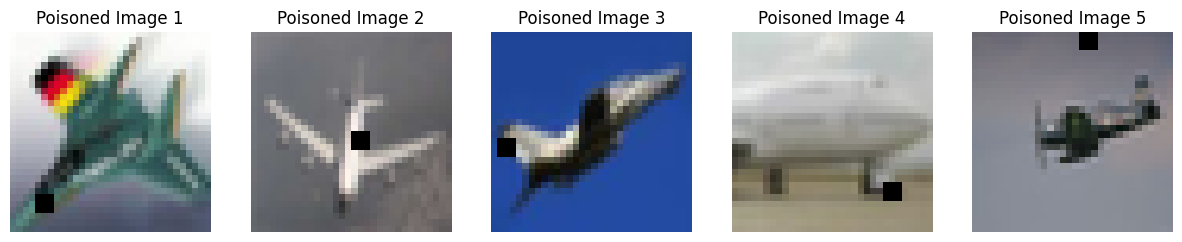

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Shard [0], Epoch [1/3], Loss: 1.8800, Accuracy: 31.60%
Shard [0], Epoch [2/3], Loss: 1.3581, Accuracy: 53.40%
Shard [0], Epoch [3/3], Loss: 1.0745, Accuracy: 65.40%
Shard [0], Epoch [1/3], Loss: 1.1873, Accuracy: 62.83%
Shard [0], Epoch [2/3], Loss: 0.8799, Accuracy: 73.67%
Shard [0], Epoch [3/3], Loss: 0.7263, Accuracy: 78.90%
Shard [0], Epoch [1/3], Loss: 0.8678, Accuracy: 74.68%
Shard [0], Epoch [2/3], Loss: 0.6550, Accuracy: 80.62%
Shard [0], Epoch [3/3], Loss: 0.5474, Accuracy: 84.00%
Shard [0], Epoch [1/3], Loss: 0.6699, Accuracy: 80.69%
Shard [0], Epoch [2/3], Loss: 0.5107, Accuracy: 84.86%
Shard [0], Epoch [3/3], Loss: 0.4282, Accuracy: 87.62%
Shard [0], Epoch [1/3], Loss: 0.5148, Accuracy: 85.53%
Shard [0], Epoch [2/3], Loss: 0.3834, Accuracy: 89.01%
Shard [0], Epoch [3/3], Loss: 0.3240, Accuracy: 90.76%
Shard [1], Epoch [1/3], Loss: 1.9395, Accuracy: 29.00%
Shard [1], Epoch [2/3], Loss: 1.3929, Accuracy: 53.45%
Shard [1], Epoch [3/3], Loss: 1.2159, Accuracy: 61.35%
Shard [1],

In [ ]:
import matplotlib.pyplot as plt
import torch
import copy

print(f"Using device: {device}")

epochs_per_slice = 3
shards = 5
slices = 5

train_loader, test_loader = load_and_preprocess_data()

train_set = copy.deepcopy(train_loader.dataset)
train_set.data, poisoned_indices = add_poison(train_set.data, train_set.targets, 3, 0, 0.1, 0, flag=True, is_test=False)
poisoned_train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=False)

# Function to visualize the images
def visualize_poisoned_images(data, poisoned_indices, num_images=5):
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(poisoned_indices[:num_images]):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(data[idx].astype(np.uint8))
        plt.title(f"Poisoned Image {i+1}")
        plt.axis('off')
    plt.show()

# Visualize some of the poisoned images
visualize_poisoned_images(train_set.data, poisoned_indices)

# Train models using SISA with pre-poisoned data loader
poisoned_trained_models = sisa_training(poisoned_train_loader.dataset, shards, slices, epochs_per_slice, device)

# Evaluate the trained models
accuracy, f1, recall, precision, auroc = evaluate_models(poisoned_trained_models, test_loader, device)

# Print evaluation metrics
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUROC: {auroc}")

#Add On. Simulation Question 2:

In [ ]:
def ASR_calculation(models_list, test_loader, class_index, device):
    all_labels = []
    all_probs = []
    all_preds = []

    # Set all models to evaluation mode
    for models in models_list:
        models[-1].eval()

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Collect predictions and probabilities from all models
            model_probs = []
            for models in models_list:
                model = models[-1]
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1)
                model_probs.append(probs.cpu().numpy())

            # Average probabilities
            avg_probs = np.mean(np.array(model_probs), axis=0)
            majority_vote_preds = np.argmax(avg_probs, axis=1)

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(avg_probs)
            all_preds.extend(majority_vote_preds)

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    # Calculate percentage of wrong predictions for class_index
    total_samples = len(all_labels)
    wrong_predictions = sum(1 for true_label, pred_label in zip(all_labels, all_preds) if pred_label != class_index)
    percentage_wrong = (wrong_predictions / total_samples) * 100

    return accuracy, percentage_wrong

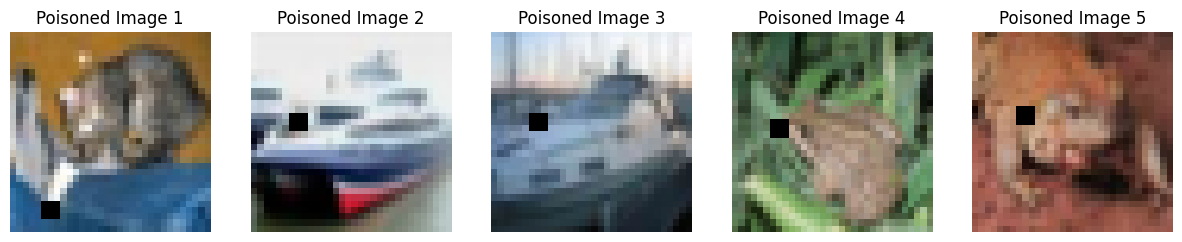

Accuracy: 0.75%
Percentage of wrong predictions for class 0: 87.79%


In [ ]:
test_set = copy.deepcopy(test_loader.dataset)
test_set.data, poisoned_indices_test = add_poison(test_set.data, test_set.targets, 3, 0, 0.1, 0, flag=True, is_test=True)
poisoned_test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

# Function to visualize the images
def visualize_poisoned_images(data, poisoned_indices, num_images=5):
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(poisoned_indices[:num_images]):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(data[idx].astype(np.uint8))
        plt.title(f"Poisoned Image {i+1}")
        plt.axis('off')
    plt.show()

# Visualize some of the poisoned images
visualize_poisoned_images(test_set.data, poisoned_indices_test)


accuracy, percentage_wrong = ASR_calculation(poisoned_trained_models, poisoned_test_loader, 0, device)
print(f"Accuracy: {accuracy:.2f}%")
print(f"Percentage of wrong predictions for class {0}: {percentage_wrong:.2f}%")

In [ ]:
poisoned_trained_models = sisa_unlearning(poisoned_trained_models, list(poisoned_indices), shards, slices, epochs_per_slice, poisoned_train_loader.dataset, device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Shard [0], Epoch [1/3], Loss: 1.9289, Accuracy: 33.45%
Shard [0], Epoch [2/3], Loss: 1.2250, Accuracy: 58.16%
Shard [0], Epoch [3/3], Loss: 0.8441, Accuracy: 73.42%
Shard [0], Epoch [1/3], Loss: 1.0601, Accuracy: 67.04%
Shard [0], Epoch [2/3], Loss: 0.7074, Accuracy: 79.00%
Shard [0], Epoch [3/3], Loss: 0.5324, Accuracy: 83.57%
Shard [0], Epoch [1/3], Loss: 0.7499, Accuracy: 77.94%
Shard [0], Epoch [2/3], Loss: 0.5430, Accuracy: 84.01%
Shard [0], Epoch [3/3], Loss: 0.4119, Accuracy: 87.71%
Shard [0], Epoch [1/3], Loss: 0.6052, Accuracy: 82.25%
Shard [0], Epoch [2/3], Loss: 0.3887, Accuracy: 88.62%
Shard [0], Epoch [3/3], Loss: 0.3041, Accuracy: 91.47%
Shard [0], Epoch [1/3], Loss: 0.4632, Accuracy: 86.77%
Shard [0], Epoch [2/3], Loss: 0.3143, Accuracy: 91.18%
Shard [0], Epoch [3/3], Loss: 0.2530, Accuracy: 92.82%
Shard [1], Epoch [1/3], Loss: 1.9578, Accuracy: 29.25%
Shard [1], Epoch [2/3], Loss: 1.2420, Accuracy: 57.70%
Shard [1], Epoch [3/3], Loss: 0.8622, Accuracy: 72.16%
Shard [1],

In [ ]:
accuracy, percentage_wrong = ASR_calculation(poisoned_trained_models, poisoned_test_loader, 0, device)
print(f"Accuracy: {accuracy:.2f}%")
print(f"Percentage of wrong predictions for class {0}: {percentage_wrong:.2f}%")

Accuracy: 0.75%
Percentage of wrong predictions for class 0: 88.80%
